
# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is straightforward to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks.

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/backprop_diagram.png' width=550px>

In the forward pass through the network, our data and operations go from bottom to top here. We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$. The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$. Finally we calculate the loss $\ell$. We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Note:** I'm glossing over a few details here that require some knowledge of vector calculus, but they aren't necessary to understand what's going on.

We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.4.0
	• tf.keras version: 2.4.0
	• GPU device not found. Running on CPU


## Load the Dataset

In [5]:
training_set, dataset_info = tfds.load('mnist', split='train', as_supervised = True, with_info = True)

## Create Pipeline

In [6]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

num_training_examples = dataset_info.splits['train'].num_examples

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)

## Build the Model

In [7]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

## Getting the Model Ready For Training

Before we can train our model we need to set the parameters we are going to use to train it. We can configure our model for training using the `.compile` method. The main parameters we need to specify in the `.compile` method are:

* **Optimizer:** The algorithm that we'll use to update the weights of our model during training. Throughout these lessons we will use the [`adam`](http://arxiv.org/abs/1412.6980) optimizer. Adam is an optimization of the stochastic gradient descent algorithm. For a full list of the optimizers available in `tf.keras` check out the [optimizers documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers#classes).


* **Loss Function:** The loss function we are going to use during training to measure the difference between the true labels of the images in your dataset and the predictions made by your model. In this lesson we will use the `sparse_categorical_crossentropy` loss function. We use the `sparse_categorical_crossentropy` loss function when our dataset has labels that are integers, and the `categorical_crossentropy` loss function when our dataset has one-hot encoded labels. For a full list of the loss functions available in `tf.keras` check out the [losses documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses#classes).


* **Metrics:** A list of metrics to be evaluated by the model during training. Throughout these lessons we will measure the `accuracy` of our model. The `accuracy` calculates how often our model's predictions match the true labels of the images in our dataset. For a full list of the metrics available in `tf.keras` check out the [metrics documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics#classes).

These are the main parameters we are going to set throught these lesson. You can check out all the other configuration parameters in the [TensorFlow documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#compile)

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Taking a Look at the Loss and Accuracy Before Training

Before we train our model, let's take a look at how our model performs when it is just using random weights. Let's take a look at the `loss` and `accuracy` values when we pass a single batch of images to our un-trained model. To do this, we will use the `.evaluate(data, true_labels)` method. The `.evaluate(data, true_labels)` method compares the predicted output of our model on the given `data` with the given `true_labels` and returns the `loss` and `accuracy` values.

In [11]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

2/2 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.90 - 0s 10ms/step - loss: 0.1073 - accuracy: 0.9531

Loss before training: 0.107
Accuracy before training: 95.312%


## Training the Model

Now let's train our model by using all the images in our training set. Some nomenclature, one pass through the entire dataset is called an *epoch*. To train our model for a given number of epochs we use the `.fit` method, as seen below:

In [10]:
EPOCHS = 5

history = model.fit(training_batches, epochs = EPOCHS)

Epoch 1/5
938/938 [==============================] - ETA: 23:17 - loss: 2.3312 - accuracy: 0.093 - ETA: 6s - loss: 2.0970 - accuracy: 0.3090  - ETA: 4s - loss: 1.6954 - accuracy: 0.52 - ETA: 4s - loss: 1.3872 - accuracy: 0.62 - ETA: 4s - loss: 1.2439 - accuracy: 0.66 - ETA: 4s - loss: 1.0869 - accuracy: 0.70 - ETA: 4s - loss: 1.0156 - accuracy: 0.72 - ETA: 4s - loss: 0.9178 - accuracy: 0.74 - ETA: 4s - loss: 0.8567 - accuracy: 0.76 - ETA: 4s - loss: 0.7975 - accuracy: 0.78 - ETA: 4s - loss: 0.7648 - accuracy: 0.78 - ETA: 4s - loss: 0.7254 - accuracy: 0.79 - ETA: 4s - loss: 0.6997 - accuracy: 0.80 - ETA: 4s - loss: 0.6886 - accuracy: 0.80 - ETA: 4s - loss: 0.6664 - accuracy: 0.81 - ETA: 4s - loss: 0.6437 - accuracy: 0.82 - ETA: 4s - loss: 0.6332 - accuracy: 0.82 - ETA: 4s - loss: 0.6166 - accuracy: 0.82 - ETA: 4s - loss: 0.6005 - accuracy: 0.83 - ETA: 4s - loss: 0.5803 - accuracy: 0.83 - ETA: 4s - loss: 0.5629 - accuracy: 0.84 - ETA: 3s - loss: 0.5452 - accuracy: 0.84 - ETA: 3s - loss: 

938/938 [==============================] - ETA: 27s - loss: 0.1283 - accuracy: 0.937 - ETA: 3s - loss: 0.0839 - accuracy: 0.971 - ETA: 3s - loss: 0.0842 - accuracy: 0.97 - ETA: 3s - loss: 0.0764 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0674 - accuracy: 0.97 - ETA: 3s - loss: 0.0701 - accuracy: 0.97 - ETA: 3s - loss: 0.0725 - accuracy: 0.97 - ETA: 3s - loss: 0.0744 - accuracy: 0.97 - ETA: 3s - loss: 0.0735 - accuracy: 0.97 - ETA: 3s - loss: 0.0760 - accuracy: 0.97 - ETA: 3s - loss: 0.0785 - accuracy: 0.97 - ETA: 3s - loss: 0.0786 - accuracy: 0.97 - ETA: 3s - loss: 0.0798 - accuracy: 0.97 - ETA: 3s - loss: 0.0830 - accuracy: 0.97 - ETA: 3s - loss: 0.0848 - accuracy: 0.97 - ETA: 3s - loss: 0.0845 - accuracy: 0.97 - ETA: 3s - loss: 0.0841 - accuracy: 0.97 - ETA: 3s - loss: 0.0822 - accuracy: 0.97 - ETA: 2s - loss: 0.0826 - accuracy: 0.97 - ETA: 2s - loss: 0.0831 - accuracy: 0.97 - ETA: 2s - loss: 0.0830 - accuracy: 0.97 - ETA: 2s - loss: 0.0822 - accur

938/938 [==============================] - ETA: 24s - loss: 0.0189 - accuracy: 1.000 - ETA: 4s - loss: 0.0446 - accuracy: 0.984 - ETA: 3s - loss: 0.0488 - accuracy: 0.98 - ETA: 3s - loss: 0.0485 - accuracy: 0.98 - ETA: 3s - loss: 0.0488 - accuracy: 0.98 - ETA: 4s - loss: 0.0527 - accuracy: 0.98 - ETA: 4s - loss: 0.0507 - accuracy: 0.98 - ETA: 4s - loss: 0.0499 - accuracy: 0.98 - ETA: 4s - loss: 0.0500 - accuracy: 0.98 - ETA: 4s - loss: 0.0526 - accuracy: 0.98 - ETA: 3s - loss: 0.0517 - accuracy: 0.98 - ETA: 3s - loss: 0.0521 - accuracy: 0.98 - ETA: 3s - loss: 0.0502 - accuracy: 0.98 - ETA: 3s - loss: 0.0526 - accuracy: 0.98 - ETA: 3s - loss: 0.0520 - accuracy: 0.98 - ETA: 3s - loss: 0.0513 - accuracy: 0.98 - ETA: 3s - loss: 0.0513 - accuracy: 0.98 - ETA: 3s - loss: 0.0504 - accuracy: 0.98 - ETA: 3s - loss: 0.0509 - accuracy: 0.98 - ETA: 3s - loss: 0.0521 - accuracy: 0.98 - ETA: 3s - loss: 0.0511 - accuracy: 0.98 - ETA: 3s - loss: 0.0508 - accuracy: 0.98 - ETA: 3s - loss: 0.0515 - accur

The `.fit` method returns a `History` object which contains a record of training accuracy and loss values at successive epochs, as well as validation accuracy and loss values when applicable. We will discuss the history object in a later lesson. 

With our model trained, we can check out it's predictions.

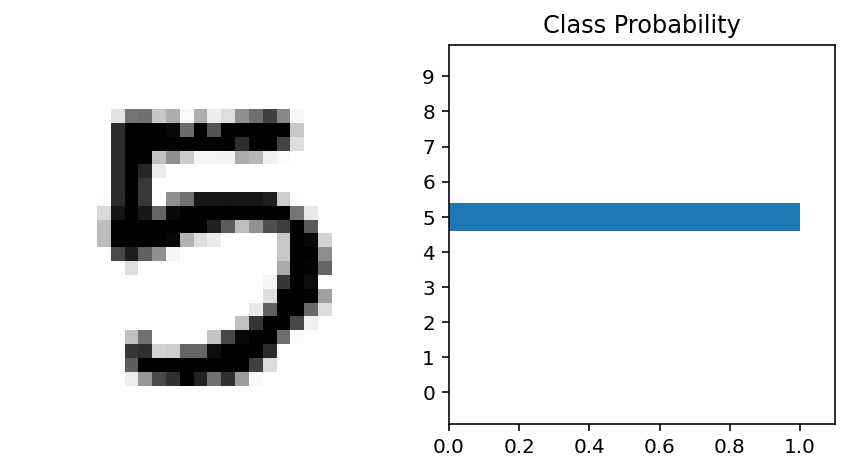

In [25]:
for image_batch, label_batch in training_batches.take(1):
    ps = model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
  
  
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

WOW!! Now our network is brilliant. It can accurately predict the digits in our images. Let's take a look again at the loss and accuracy values for a single batch of images.

In [26]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

2/2 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 1.00 - 0s 8ms/step - loss: 0.0123 - accuracy: 1.0000

Loss after training: 0.012
Accuracy after training: 100.000%


> **Exercise:** Create a network with 784 input units, a hidden layer with 128 units, then a hidden layer with 64 units, then a hidden layer with 32 units and finally an output layer with 10 units. Use a ReLu activation function for all the hidden layers and a softmax activation function for the output layer. Then compile the model using an `adam` optimizer, a `sparse_categorical_crossentropy` loss function, and the `accuracy` metric. Finally, print the loss and accuracy of your un-trained model for a single batch of images.

In [30]:
## Solution
model_1 = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model_1.evaluate(image_batch, label_batch)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

2/2 [==============================] - ETA: 0s - loss: 2.3736 - accuracy: 0.12 - 0s 6ms/step - loss: 2.3440 - accuracy: 0.1458

Loss before training: 2.329
Accuracy before training: 15.625%


> **Exercise:** Train the model you created above for 5 epochs and then print the loss and accuracy of your trained model for a single batch of images.

In [31]:
## Solution
EPOCHS = 5
history = model_1.fit(training_batches, epochs = EPOCHS)

for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model_1.evaluate(image_batch, label_batch)


print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

Epoch 1/5
938/938 [==============================] - ETA: 9:37 - loss: 2.3208 - accuracy: 0.12 - ETA: 3s - loss: 2.0910 - accuracy: 0.3498 - ETA: 3s - loss: 1.8198 - accuracy: 0.44 - ETA: 3s - loss: 1.5739 - accuracy: 0.52 - ETA: 3s - loss: 1.3566 - accuracy: 0.59 - ETA: 3s - loss: 1.1711 - accuracy: 0.65 - ETA: 3s - loss: 1.0568 - accuracy: 0.68 - ETA: 3s - loss: 0.9665 - accuracy: 0.71 - ETA: 3s - loss: 0.9154 - accuracy: 0.72 - ETA: 3s - loss: 0.8609 - accuracy: 0.74 - ETA: 3s - loss: 0.8151 - accuracy: 0.75 - ETA: 3s - loss: 0.7791 - accuracy: 0.76 - ETA: 3s - loss: 0.7450 - accuracy: 0.77 - ETA: 3s - loss: 0.7182 - accuracy: 0.78 - ETA: 3s - loss: 0.6871 - accuracy: 0.79 - ETA: 3s - loss: 0.6640 - accuracy: 0.80 - ETA: 3s - loss: 0.6371 - accuracy: 0.81 - ETA: 3s - loss: 0.6156 - accuracy: 0.82 - ETA: 3s - loss: 0.5973 - accuracy: 0.82 - ETA: 3s - loss: 0.5798 - accuracy: 0.82 - ETA: 3s - loss: 0.5607 - accuracy: 0.83 - ETA: 3s - loss: 0.5475 - accuracy: 0.83 - ETA: 3s - loss: 0.5

938/938 [==============================] - ETA: 30s - loss: 0.1928 - accuracy: 0.921 - ETA: 3s - loss: 0.0910 - accuracy: 0.966 - ETA: 3s - loss: 0.0904 - accuracy: 0.97 - ETA: 3s - loss: 0.0814 - accuracy: 0.97 - ETA: 3s - loss: 0.0844 - accuracy: 0.97 - ETA: 3s - loss: 0.0901 - accuracy: 0.97 - ETA: 3s - loss: 0.0912 - accuracy: 0.97 - ETA: 3s - loss: 0.0908 - accuracy: 0.97 - ETA: 3s - loss: 0.0883 - accuracy: 0.97 - ETA: 3s - loss: 0.0871 - accuracy: 0.97 - ETA: 3s - loss: 0.0870 - accuracy: 0.97 - ETA: 3s - loss: 0.0863 - accuracy: 0.97 - ETA: 3s - loss: 0.0868 - accuracy: 0.97 - ETA: 3s - loss: 0.0838 - accuracy: 0.97 - ETA: 3s - loss: 0.0843 - accuracy: 0.97 - ETA: 3s - loss: 0.0854 - accuracy: 0.97 - ETA: 3s - loss: 0.0858 - accuracy: 0.97 - ETA: 3s - loss: 0.0862 - accuracy: 0.97 - ETA: 3s - loss: 0.0858 - accuracy: 0.97 - ETA: 3s - loss: 0.0845 - accuracy: 0.97 - ETA: 3s - loss: 0.0862 - accuracy: 0.97 - ETA: 3s - loss: 0.0857 - accuracy: 0.97 - ETA: 3s - loss: 0.0872 - accur

2/2 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 1.00 - 0s 7ms/step - loss: 0.0148 - accuracy: 1.0000

Loss after training: 0.015
Accuracy after training: 100.000%


> **Exercise:** Plot the prediction of the model you created and trained above on a single image from the training set. Also plot the probability predicted by your model for each digit.

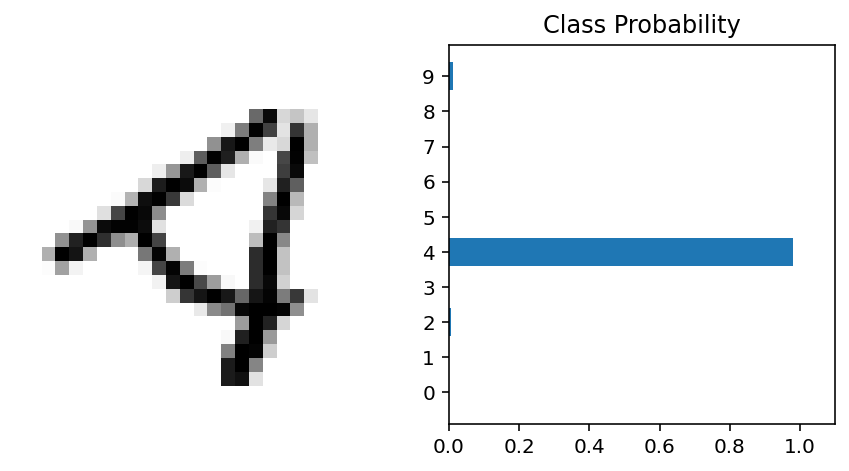

In [29]:
## Solution
for image_batch, label_batch in training_batches.take(1):
    ps = model_1.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
   
  
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

## Automatic Differentiation

Let's now take a minute to see how TensorFlow calculates and keeps track of the gradients needed for backpropagation. TensorFlow provides a class that records automatic differentiation operations, called `tf.GradientTape`. Automatic differentiation, also known as algorithmic differentiation or simply “autodiff”, is a family of techniques used by computers for efficiently and accurately evaluating derivatives of numeric functions.

`tf.GradientTape` works by keeping track of operations performed on tensors that are being "watched". By default `tf.GradientTape` will automatically "watch" any trainable variables, such as the weights in our model. Trainable variables are those that have `trainable=True`. When we create a model with `tf.keras`, all of the parameters are initialized with `trainable = True`. Any tensor can also be manually "watched" by invoking the watch method.


Let's see a simple example. Let's take the following equation:

$$
y = x^2
$$

The derivative of `y` with respect to `x` is given by:

$$
\frac{d y}{d x} = 2x
$$

Now, let's use `tf.GradientTape` to calculate the derivative of a tensor `y` with respect to a tensor `x`:

In [32]:
# Set the random seed so things are reproducible
tf.random.set_seed(7)

# Create a random tensor
x = tf.random.normal((2,2))

# Calculate gradient
with tf.GradientTape() as g:
    g.watch(x)
    y = x ** 2
    
dy_dx = g.gradient(y, x)

# Calculate the actual gradient of y = x^2
true_grad = 2 * x

# Print the gradient calculated by tf.GradientTape
print('Gradient calculated by tf.GradientTape:\n', dy_dx)

# Print the actual gradient of y = x^2
print('\nTrue Gradient:\n', true_grad)

# Print the maximum difference between true and calculated gradient
print('\nMaximum Difference:', np.abs(true_grad - dy_dx).max())

Gradient calculated by tf.GradientTape:
 tf.Tensor(
[[1.1966898  0.12552415]
 [0.29263484 0.9696375 ]], shape=(2, 2), dtype=float32)

True Gradient:
 tf.Tensor(
[[1.1966898  0.12552415]
 [0.29263484 0.9696375 ]], shape=(2, 2), dtype=float32)

Maximum Difference: 0.0


The `tf.GradientTape` class keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor.

To know more about `tf.GradientTape` and trainable variables check the following links

* [Gradient Tape](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape)

* [TensorFlow Variables](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/Variable)

Next up you'll write the code for training a neural network on a more complex dataset.